# Proyek Klasifikasi Gambar: Klasifikasi Retina Mata (Binary Classification)
- **Nama:** Labiba Adinda Zahwana
- **Email:** labibaadinda11@gmail.com

Proyek ini mengembangkan model deep learning untuk mengklasifikasikan gambar retina dan non-retina secara biner. Dataset yang digunakan berisi gambar retina berkualitas tinggi dan gambar non-retina sebagai pembanding. Proyek ini bisa dikembangkan untuk bidang oftalmologi dan berpotensi dikembangkan untuk biometrik, karena pola retina tiap orang unik.

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install keras-tuner


In [ ]:
!pip install scikeras


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf

import pandas as pd
import numpy as np
from PIL import Image, ImageFile
from collections import defaultdict, Counter
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from scikeras.wrappers import KerasClassifier, KerasRegressor

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from pathlib import Path

# Jika pakai Jupyter notebook atau Google Colab, aktifkan magic command matplotlib:
# %matplotlib inline

# Mount Google Drive di Colab:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Data Preparation

### Data Loading

In [ ]:
data_dir = Path("/content/drive/MyDrive/Submission/ml_pengembangan/dataset")
data = []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                data.append({'images': fname, 'label': class_name})

In [ ]:
# inisialisasi variabel penampung
label_counts = defaultdict(int)
resolution_counter = Counter()
resolution_per_label = defaultdict(set)

# loop menghitung jumlah data & resolusi data dalam dataset
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    label_counts[label] += 1
                    resolution = img.size  # (width, height)
                    resolution_counter[resolution] += 1
                    resolution_per_label[label].add(resolution)
            except Exception as e:
                print(f"Gagal membuka {img_path}: {e}")

In [ ]:
print("\nResolusi gambar dalam dataset:")
for label, resolutions in resolution_per_label.items():
    print(f"{label}: {list(resolutions)}\n")


Resolusi gambar dalam dataset:
train_images: [(474, 358), (2896, 1944), (3216, 2136), (2416, 1736), (1467, 1110), (2048, 1536), (640, 480), (2144, 1424), (2146, 1764), (3388, 2588), (2588, 1958), (1476, 1117), (1050, 1050), (4288, 2848), (1504, 1000), (819, 614), (1844, 1226)]

non-dr: [(500, 435), (516, 550), (640, 329), (500, 444), (1200, 1600), (500, 453), (1050, 749), (500, 471), (649, 423), (446, 500), (593, 519), (500, 300), (1440, 800), (625, 331), (500, 309), (500, 318), (531, 800), (750, 600), (500, 327), (867, 996), (494, 494), (300, 400), (500, 336), (274, 500), (550, 413), (752, 557), (800, 695), (1500, 2000), (656, 440), (239, 380), (380, 267), (293, 360), (500, 421), (450, 600), (500, 430), (389, 581), (380, 285), (360, 270), (500, 439), (614, 461), (400, 361), (500, 448), (342, 249), (381, 329), (188, 200), (361, 500), (1000, 734), (800, 578), (802, 1024), (1393, 1083), (600, 800), (729, 545), (429, 253), (389, 217), (680, 500), (560, 355), (418, 500), (600, 400), (500,

In [ ]:
df = pd.DataFrame(data)

# Lanjut split dataset jadi train, val, test...
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 4551, Validation: 1517, Test: 1517


## Data Splitting

In [ ]:
train_df['filepath'] = train_df['label'] + '/' + train_df['images']
val_df['filepath'] = val_df['label'] + '/' + val_df['images']
test_df['filepath'] = test_df['label'] + '/' + test_df['images']

In [ ]:
print(f"Train {train_df['label'].value_counts()} \n")
print(f"Val {val_df['label'].value_counts()} \n")
print(f"Test {test_df['label'].value_counts()} \n")

Train label
non-dr          2353
train_images    2198
Name: count, dtype: int64 

Val label
non-dr          785
train_images    732
Name: count, dtype: int64 

Test label
non-dr          785
train_images    732
Name: count, dtype: int64 



In [ ]:
class_names = train_df['label'].unique().tolist()
print(class_names)

['non-dr', 'train_images']


In [ ]:
print(train_df['images'].head(10))
print(train_df['label'].head(10))


5946    ILSVRC2012_val_00015433.JPEG
1948                b468ebf5cb11.png
682                 e82232a3c28b.png
1596                9f37c98b8187.png
5172    ILSVRC2012_val_00031461.JPEG
3135                0a902c80d5da.png
4666    ILSVRC2012_val_00023615.JPEG
5981    ILSVRC2012_val_00015917.JPEG
3077                042470a92154.png
303                 cf0824f53dd9.png
Name: images, dtype: object
5946          non-dr
1948    train_images
682     train_images
1596    train_images
5172          non-dr
3135    train_images
4666          non-dr
5981          non-dr
3077    train_images
303     train_images
Name: label, dtype: object


## Data Augmentation

In [ ]:
# Buat ImageDataGenerator untuk training dan validasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Train generator dari dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=str(data_dir),
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Validation generator dari dataframe
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=str(data_dir),
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Test generator dari dataframe
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=str(data_dir),
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 4551 validated image filenames belonging to 2 classes.
Found 1517 validated image filenames belonging to 2 classes.
Found 1517 validated image filenames belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt

def show_images_from_generator(generator, class_names, title):
    plt.figure(figsize=(6,6))
    images, labels = next(generator)  # ambil 1 batch gambar dan label
    for i in range(min(9, len(images))):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        label_index = labels[i].argmax()  # asumsi one-hot encoding
        plt.title(class_names[label_index])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

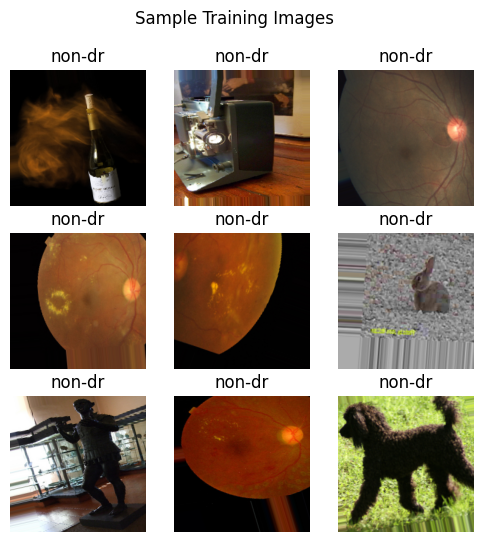

In [ ]:
show_images_from_generator(train_generator, class_names, "Sample Training Images")

## Modelling

### Hyperparameter Optimization

disini saya cari hyperparameter terbaik dengan menggunakan tuner

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=3,
        activation='relu',
        input_shape=(224,224,3)
    ))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='retina_tuning'
)

tuner.search(train_generator, validation_data=validation_generator, epochs=10)

Trial 4 Complete [00h 26m 01s]
val_accuracy: 0.9986816048622131

Best val_accuracy So Far: 0.9986816048622131
Total elapsed time: 01h 50m 31s


Download tuner (algo untuk search best model)

In [ ]:
# Setelah tuning selesai, kompres folder 'my_dir' (tempat penyimpanan hasil tuner) jadi zip
import shutil
from google.colab import files

shutil.make_archive('/content/my_dir', 'zip', '/content/my_dir')

# Download file ZIP hasil kompresi
files.download('/content/my_dir.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Build Best Model

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
history = best_model.fit(
    train_generator, # fit() digunakan untuk melatih model.
    validation_data=validation_generator, # data validasi digunakan untuk mengevaluasi kinerja model pada data yang tidak terlihat selama pelatihan.
    epochs=5 # total iterasi
)

Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 752s 5s/step - accuracy: 0.9809 - loss: 0.0846 - val_accuracy: 0.9980 - val_loss: 0.0056
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 737s 5s/step - accuracy: 0.9975 - loss: 0.0080 - val_accuracy: 0.9967 - val_loss: 0.0124
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 743s 5s/step - accuracy: 0.9949 - loss: 0.0169 - val_accuracy: 0.9993 - val_loss: 0.0021
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 736s 5s/step - accuracy: 0.9947 - loss: 0.0174 - val_accuracy: 0.9980 - val_loss: 0.0122
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 744s 5s/step - accuracy: 0.9959 - loss: 0.0141 - val_accuracy: 0.9967 - val_loss: 0.0171


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 788544)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       788,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371,013 (9.04 MB)

 Trainable params: 790,337 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,580,676 (6.03 MB)

## Evaluation

In [ ]:
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9984 - loss: 0.0094
Test Accuracy: 1.00
Test Loss: 0.01


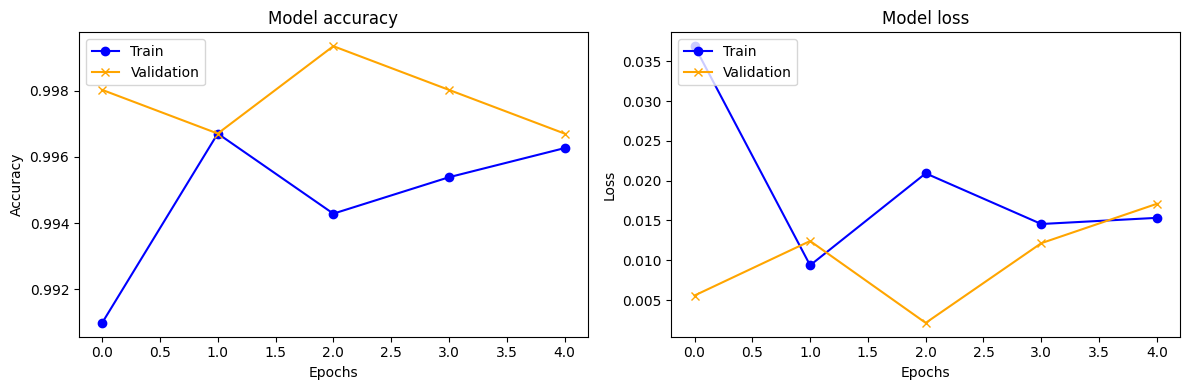

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', color='blue')
plt.plot(history.history['val_accuracy'], marker='x', color='orange')
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', color='blue')
plt.plot(history.history['val_loss'], marker='x', color='orange')
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Konversi Model

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# Menyimpan model dalam format SavedModel
best_model.export('/content/saved_model')

# Mengompres folder saved_model menjadi file ZIP
shutil.make_archive('/content/saved_model', 'zip', '/content', 'saved_model')

# Mengunduh file ZIP yang berisi model
files.download('/content/saved_model.zip')

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138527121021200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138527121020432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138527121020240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138527110754192: TensorSpec(shape=(), dtype=tf.resource, name=None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflowjs as tfjs
import shutil
from google.colab import files

# 1. Mengonversi model ke format TensorFlow.js
tfjs.converters.save_keras_model(best_model, '/content/tfjs_model')

# 2. Mengompres folder tfjs_model menjadi file ZIP
shutil.make_archive('/content/tfjs_model', 'zip', '/content', 'tfjs_model')

# 3. Mengunduh file ZIP yang berisi model TensorFlow.js
files.download('/content/tfjs_model.zip')

failed to lookup keras version from the file,
    this is likely a weight only file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Menggunakan TFLiteConverter untuk mengonversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

# Konversi model ke TFLite
tflite_model = converter.convert()

# Tentukan path di Google Colab untuk menyimpan model TFLite
tflite_model_file = '/content/model.tflite'

# Menyimpan model TFLite ke file
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

print(f"Model berhasil disimpan ke {tflite_model_file}")

Saved artifact at '/tmp/tmpkhp3w8rx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138527121021200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138527121020432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138527121020240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138527110754192: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil disimpan ke /content/model.tflite


In [30]:
from google.colab import files

# Mengunduh model TFLite yang telah disimpan
files.download(tflite_model_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
import os

# Membuat direktori 'tflite/' jika belum ada
os.makedirs('tflite', exist_ok=True)

# Simpan label ke dalam file label.txt
with open('tflite/label.txt', 'w') as f:
    # Use the already defined variable 'class_names'
    for label in class_names:
        f.write(f"{label}\n")

print("Label berhasil disimpan ke 'tflite/label.txt'")

Label berhasil disimpan ke 'tflite/label.txt'
